# <span style="color:turquoise">Text classification with pytorch</span>


An example of using natural language processing for sentiment analysis. <br> Building a binary classifier of movie reviews that will predict if a review is positive or negative.




__Dataset:__ IMDB movie reviews from Kaggle<br>
__Model:__ LSTM


In [1]:
import csv
import random
import numpy as np
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## <span style="color:teal">Read the data and split it into training, cross-validation, and test sets</span>

In [2]:
class Reviews():
    
    def __init__(self):
        self.train = {}
        self.val = {}
        self.test = {}
        self.LABELS = {"positive":1, "negative": 0}
        self.COUNT = {"positive": 0, "negative": 0}
    
    
    def read_data(self):
        
        dataset = []
        
        with open ("IMDB_Dataset.csv", newline='') as f:
            datareader = csv.reader(f, delimiter=',')
            next(datareader, None)

            for row in datareader:
                dataset.append([row[0], self.LABELS[row[1]]])
                self.COUNT[row[1]] += 1
            
            random.shuffle(dataset)
                
        return dataset




    def split_dataset(self,
                      dataset,
                      split=[int(50000*0.6), int(50000*0.2), int(50000*0.2)]):
        
        train, val, test = torch.utils.data.random_split(dataset,
                                               split,
                                               generator=torch.Generator().manual_seed(43))
          
            
        return train, val, test

In [3]:
rev = Reviews()
data = rev.read_data()
pos_count = rev.COUNT["positive"]
neg_count = rev.COUNT["negative"]


In [4]:
print(data[10])

['I had the privilege to see this movie at the Intenational Film Festival of Rotterdam. ', 1]


In [5]:
train, val, test = rev.split_dataset(data)
print(train[10])

["I watched this movie when Joe Bob Briggs hosted Monstervision on TNT. Even he couldn't make this movie enjoyable. The only reason I watched it until the end is because I teach video production and I wanted to make sure my students never made anything this bad ... but it took all my intestinal fortitude to sit through it though. It's like watching your great grandmother flirting with a 15 year old boy ... excruciatingly painful. If you see this movie in the bargin bin at S-Mart, back away from it as if it were a rattlesnake.", 0]


In [6]:
print(len(train), len(val), len(test))

30000 10000 10000


In [7]:
def split_x_and_y(data):
    x = []
    y = []
    for review, label in data:
        x.append(review)
        y.append(label)
    return x, np.array(y)

In [8]:
train_x_raw, train_y = split_x_and_y(train)
val_x_raw, val_y = split_x_and_y(val)
test_x_raw, test_y = split_x_and_y(test)


print(len(train_x_raw), len(train_y))
#print(train_x_raw[50], train_y[50])

# Check if datasets are balanced - how many positive reviews in each
print(np.count_nonzero(train_y), np.count_nonzero(val_y), np.count_nonzero(test_y))

30000 30000
14944 5014 5042


## <span style="color:teal">Preprocess text</span>

In [9]:
def preprocess(review,
               remove_stopwords=False, 
               remove_html=True, 
               remove_punct=False, 
               lowercase=False, 
               lemmatize=False,
               maxlen=None):
    
    review = re.sub(r"\'", "'", review)
    review = re.sub(r"\x96", "-", review)
    
    if remove_html:
        review = re.sub(r'<.*>', ' ', review)
    
    review = word_tokenize(review)
        
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        review = [w for w in review if w not in stop_words]
        
    if remove_punct:
        contractions = ["'ll", "'s", "n't", "'d", "'m", "'ve", "'re"]
        review = [w for w in review if w.isalnum() or w in contractions]
    
    if lowercase:
        review = [w.lower() for w in review]
        
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        review = [lemmatizer.lemmatize(w) for w in review]
    
    
    return review[:maxlen]
    


In [10]:
train_words = [preprocess(review, 
                      lowercase=True, 
                      remove_punct=True,
                      remove_stopwords=True
                     ) 
           for review in train_x_raw]

val_words = [preprocess(review, 
                    lowercase=True, 
                    remove_punct=True,
                    remove_stopwords=True
                   ) 
         for review in val_x_raw]

In [11]:
print(train_words[9592], '\n', val_words[3029])
print(len(train_words[9592]), '\n', len(val_words[3029]))

['curse', "n't", 'really', 'deserve', 'long', 'detailed', 'review', 'i', "'ll", 'make', 'random', 'observations', '4'] 
 ['let', "'s", 'start', 'simple', 'lines', 'from', 'viewer', "'s", 'side', 'couple', 'good', 'director', 'details', 'points', 'view', 'movie', 'scenes', 'nice', 'the', 'special', 'effects', 'good', 'enough', 'good', 'scenery', 'also', 'but', 'story', 'way', 'simple', 'it', 'shows', 'elite', 'army', 'bomb', 'squad', 'unit', 'lives', 'acts', 'sometimes', 'dies', 'it', 'shows', 'drama', 'living', 'war', 'in', 'movie', 'experience', 'serious', 'action', 'movie', 'addicted', 'guy', 'i', 'missed', 'click', 'gets', 'eyes', 'mind', 'stuck', 'screen', 'one', 'things', 'need', 'present', 'movie', 'order', 'i', 'consider', 'good', 'one', 'ability', 'immerse', 'viewer', 'movie', 'reality', 'time', 'it', "n't", 'happened', 'i', 'stayed', 'conscious', 'entire', 'movie', 'compared', 'rivals', 'oscars', 'i', "n't", 'think', 'prizes', 'correctly', 'awarded']
13 
 95


In [12]:
print(len(train_words))

30000


## <span style="color:teal">Convert text to indices and add paddings</span>

In [13]:
def make_vocabulary(preprocessed_data, 
                    vocab_size=15000,
                    pad_token='<PAD>',
                    unk_token='<UNK>'):
    
    # Create a vocabulary list of a given size
    freqs = {}
    for review in preprocessed_data:
        for word in review:
            freqs[word] = freqs.get(word, 0) + 1
            
    freqs_list = Counter(freqs).most_common(vocab_size)
    
    assert len(freqs_list) == vocab_size
    
    # Create word-index mappings
    vocab_list = [pair[0] for pair in freqs_list]
    word2ind = {word : i+2 for i, word in enumerate(vocab_list)}
    
    # Prepend the pad token
    word2ind[pad_token] = 0
    
    # Prepend the 'unknown' token
    word2ind[unk_token] = 1

    
    return word2ind
  
    

In [14]:
word2ind = make_vocabulary(train_words, vocab_size=10000)

print(len(word2ind))
print(word2ind['i'], word2ind['awful'])

10002
2 237


In [15]:
print(word2ind['not'])

161


In [16]:
del train_x_raw, val_x_raw

In [17]:
print(np.max([len(x) for x in train_words]))
print(np.mean([len(x) for x in train_words]))

print(np.max([len(x) for x in val_words]))
print(np.mean([len(x) for x in val_words]))

612
78.06103333333333
588
78.2461


In [18]:
def make_padded_inputs(preprocessed_data, 
                       vocab, 
                       padded_length=64,
                       pad_token='<PAD>',
                       unk_token='<UNK>'):
    
    num_lines = len(preprocessed_data)
    pad = vocab[pad_token]
    
    inputs = np.full((num_lines, padded_length), pad)
    
    for i, review in enumerate(preprocessed_data):
        if len(review) <= padded_length:
            start_position = padded_length - len(review)
        else:
            start_position = 0
        for j, word in enumerate(review[:padded_length]):
            inputs[i, (start_position + j)] = vocab.get(word, vocab[unk_token])       
    return inputs
            

In [19]:
train_x = make_padded_inputs(train_words, word2ind)
val_x = make_padded_inputs(val_words, word2ind)


print(f"""Training example at indices 5 and 6:\n{train_words[5:7]}\n
    Converted to indices:\n{train_x[5:7, :]}\n""")

print(len(train_words[5]), np.count_nonzero(train_x[5]))

assert (len(train_words[5]) == np.count_nonzero(train_x[5])) or (64 == np.count_nonzero(train_x[5]))

Training example at indices 5 and 6:
[['this', 'film', 'seems', 'rip', 'many', 'movies', 'dealt', 'subject', 'past', 'let', 'future', 'viewer', 'forewarned', 'art', 'heist', "n't", 'add', 'anything', 'genre', 'director', 'bryan', 'goeres', 'clue', 'film', 'a', 'movie', 'seen', 'viewer', "'s", 'risk'], ['for', 'reason', 'look', 'remake', 'see', 'bad', 'funny', 'could', 'there', 'doubt', 'funny', 'bad', 'i', 'seen', 'voyna', 'mir', '1968', 'shall', 'begin', 'here', 'go', '4', '10', '1', 'point', 'given', 'start', '1', 'point', 'goes', 'recklessness', '2', 'points', 'last', 'part', 'serial', 'thanks', 'attention']]

    Converted to indices:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   11    6  121 2051   39   25 3038  673
   436  191  628  441    1  407 3259    7  617  156  404   76 7845    1
  1913    6   45    4   31  441    3 2748]
 [   0    0    0    0 

In [20]:
print(train_x.shape)

(30000, 64)


## <span style="color:teal">Load data into torch</span>

In [21]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

In [22]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [23]:
print(list(train_loader)[0][0][:5], '\n', list(train_loader)[0][1][:5],)

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,  612,    2,  259,  182,    6,   12,    2,  114,
           54,    6,   12,  294,  582,  418, 6796,  327,  414,    1, 1087,    1,
          226,    6,  139,  217,    5,  120,    2, 1988,    6, 1519,  120,   22,
          294,  582,    1,  508,  217,  408,    2,  747, 1431,    1, 1087,    1,
            2,    6,    1, 1164],
        [4029,    1, 7058,  512,  279, 3578, 1262,    4,  151,  200,   17,    9,
          233, 4321, 2543,   25,    1,   69, 1782,  497,   45, 2349, 1207, 6918,
          427, 2381, 2136,    1,    1, 1494,    1, 8073,  152,  926,   77,  110,
            1,   51,  840, 4875,    1,    8,    1, 3037, 1872,    1, 8074,   37,
         3848,    8,   51, 6918,  488,  154, 6280,    1, 1122,  298, 6041,  608,
           26,  316, 2350,    1],
        [  60,  368,    6,    8, 8286,  533,  513,   51, 3982,  250,  893,   41,
         1646,  837, 3734,    3,  800,  1

In [24]:
print(train_words[:1])
print(len(train_words[0]))
print(train_y[0])

[['from', 'i', 'remember', 'seeing', 'film', 'good', 'i', 'always', 'say', 'film', 'good', 'keep', 'attention', 'throughout', 'hardest', 'moments', 'example', 'tylenol', 'cold', 'sinus', 'war', 'film', 'done', 'job', 'the', 'fact', 'i', 'asleep', 'film', 'proves', 'fact', 'could', 'keep', 'attention', 'ergo', 'complete', 'job', 'why', 'i', 'fall', 'victim', 'tylenol', 'cold', 'sinus', 'i', 'film', 'arsenal', 'grade']]
48
0


In [25]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, 
                 vocab_size, 
                 d_feature, 
                 num_layers, 
                 hidden_size,
                 n_outputs,
                 dropout_rate,
                 bidirectional=False):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_feature)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(input_size=d_feature,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, n_outputs)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input_data): 
        
        embedded = self.dropout(self.embedding(input_data))
        lstm_out, _ = self.lstm(embedded)
        fc = self.fc(lstm_out[:,-1,:])
        sigmoid = self.sigmoid(fc)
   
        return sigmoid
    

In [26]:
vocab_size = len(word2ind)
d_feature = 64
hidden_size = 256
n_outputs = 1
num_layers = 1
dropout_rate = 0.4

model = SentimentClassifier(
                            vocab_size=vocab_size, 
                            d_feature=d_feature,  
                            num_layers=num_layers, 
                            hidden_size=hidden_size, 
                            n_outputs=n_outputs,
                            dropout_rate=dropout_rate).to(device)

print(model)

SentimentClassifier(
  (embedding): Embedding(10002, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## <span style="color:teal">Train model</span>

In [27]:
def accuracy(outputs, targets):
    outputs = torch.flatten(outputs)
    assert outputs.shape == targets.shape
    predicted = torch.where(outputs>=0.5, 1, 0)
    accuracy = torch.Tensor.float(predicted==targets).mean()
    return accuracy

In [28]:
def train_model(train_loader=train_loader,
             val_loader=val_loader,
             model=model,
             criterion=nn.BCELoss(),
             n_epochs=6):
    
    start_time = time.time()
    
    train_losses = []
    val_losses = []
    accs = []
    val_accs = []
    
    for epoch in range(n_epochs):
        total_loss = 0
        total_loss_val = 0
        total_acc = 0
        total_acc_val = 0
        
        model.train()
        
        for inputs, labels in train_loader: 
            optimizer= torch.optim.Adam(model.parameters(), lr=0.001)
            #scheduler= StepLR(optimizer, step_size=n_epochs//2, gamma=0.1)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.float())
            acc = accuracy(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
            total_loss += loss.item()
            total_acc += acc.item()
            
        train_losses.append(total_loss/len(train_loader))
        accs.append(total_acc/len(train_loader))
        model.eval()
        
        
        for val_inputs, val_labels in val_loader:
            val_output = model(val_inputs)
            val_loss = criterion(val_output.squeeze(), val_labels.float())
            val_acc = accuracy(val_output, val_labels)
            total_loss_val += val_loss.item()
            total_acc_val += val_acc.item()
            
            
        val_losses.append(total_loss_val/len(val_loader))
        val_accs.append(total_acc_val/len(val_loader))
        
        #scheduler.step()
        
        print(f"Epoch: {epoch+1}/{ n_epochs}\t",
              f"{((time.time() - start_time) / 60):.2f} min\t",
              f"Loss: {total_loss/len(train_loader):.3f}\t",
              f"Val Loss: {total_loss_val/len(val_loader):.3f}\t",
              f"Acc: {total_acc/len(train_loader):.3f}\t",
              f"Val Acc: {total_acc_val/len(val_loader):.3f}")
            
    print(f"Training completed in {(time.time() - start_time) / 60} min.")
    
    return accs, val_accs, train_losses, val_losses
    

In [29]:
accs, val_accs, train_losses, val_losses = train_model(n_epochs=12)

Epoch: 1/12	 1.33 min	 Loss: 0.665	 Val Loss: 0.626	 Acc: 0.600	 Val Acc: 0.674
Epoch: 2/12	 2.66 min	 Loss: 0.593	 Val Loss: 0.557	 Acc: 0.692	 Val Acc: 0.711
Epoch: 3/12	 4.04 min	 Loss: 0.531	 Val Loss: 0.504	 Acc: 0.736	 Val Acc: 0.761
Epoch: 4/12	 5.68 min	 Loss: 0.494	 Val Loss: 0.473	 Acc: 0.761	 Val Acc: 0.779
Epoch: 5/12	 7.24 min	 Loss: 0.465	 Val Loss: 0.461	 Acc: 0.781	 Val Acc: 0.784
Epoch: 6/12	 9.23 min	 Loss: 0.454	 Val Loss: 0.448	 Acc: 0.788	 Val Acc: 0.790
Epoch: 7/12	 10.70 min	 Loss: 0.437	 Val Loss: 0.453	 Acc: 0.798	 Val Acc: 0.787
Epoch: 8/12	 12.18 min	 Loss: 0.427	 Val Loss: 0.436	 Acc: 0.801	 Val Acc: 0.796
Epoch: 9/12	 13.60 min	 Loss: 0.419	 Val Loss: 0.434	 Acc: 0.810	 Val Acc: 0.797
Epoch: 10/12	 14.85 min	 Loss: 0.412	 Val Loss: 0.429	 Acc: 0.813	 Val Acc: 0.799
Epoch: 11/12	 16.13 min	 Loss: 0.401	 Val Loss: 0.421	 Acc: 0.818	 Val Acc: 0.804
Epoch: 12/12	 17.27 min	 Loss: 0.391	 Val Loss: 0.426	 Acc: 0.825	 Val Acc: 0.800
Training completed in 17.271754

In [30]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_losses, label="val")
    plt.plot(train_losses, label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [31]:
def plot_accuracies(accuracies, val_accuracies):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracies")
    plt.plot(val_accuracies, label="val")
    plt.plot(accuracies, label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

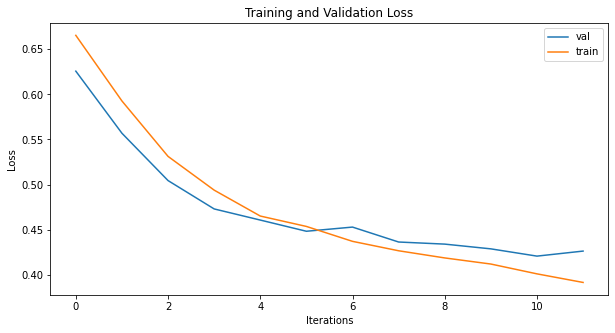

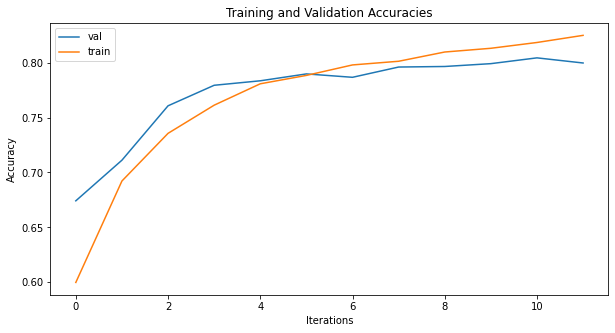

In [32]:
plot_losses(train_losses, val_losses)
plot_accuracies(accs, val_accs)

## <span style="color:teal">Make predictions</span>

In [33]:
def predict(review, vocab=word2ind, model=model):
    
    preprocessed = preprocess(review, 
                              lowercase=True, 
                              remove_punct=True, 
                              remove_stopwords=True)
    
    inputs = make_padded_inputs(preprocessed, vocab)
    pred_loader = torch.utils.data.DataLoader(torch.from_numpy(inputs), batch_size=1)
    
    model=model
    model.eval()
    
    for x in pred_loader:
        output = model(x).item()
    
    return "This review is positive" if output >= 0.5 else "This review is negative"

    
    
    

In [34]:
review = test_x_raw[871]
print(f"Review text: {review}", '\n', test_y[871])
predict(review)

Review text: All I can say is, this movie is made for the Lifetime Channel on TV, which means no solid characters, no particular style, weak acting all kinds of suggested sex but no-breasts and tushs (because boy, that would just catapult the film into the depths of sleaze wouldn't it?) but the heavily simulated sex, well, that's OK.  Don't bore yourself to death like I did. Seek out some real TV movies on HBO, Showtime, IFC, Starz, etc. Any channel that puts effort into their work and doesn't have to ask a priest what they can or cannot show. 
 0


'This review is negative'

In [35]:
review2 = test_x_raw[259]
print(review2, '\n', test_y[259])
predict(review2)

Very strange screenplay by Cameron Crowe (following on the heels of his "Fast Times at Ridgemont High") has little inspiration and flails away at dumb gags. At least "Fast Times" had a fair share of satire and sensitivity behind its slapstick (courtesy of a good director, Amy Heckerling, and Crowe's undeniable penchant for capturing letter-perfect teen-speak); here, Chris Penn (Sean's brother, natch) is the goof-off who makes life hell for straight arrow Eric Stoltz, and the filmmakers seem to think he's hilarious. Jenny Wright has some good moments as a mall-worker, but Illan Mitchell-Smith is lost in a head-scratching subplot about a teen who seems to be infatuated with a shell-shocked ex-soldier. Queasy, confused nonsense given a shiny sheen and a soundtrack full of pop-rock tunes, but characters one would hope to avoid. Supporting players Lea Thompson, Rick Moranis, Lee Ving, and Sherilyn Fenn are wasted in stupid roles. * from **** 
 0


'This review is negative'

In [47]:
predict("Fantastic film.")

'This review is positive'

In [37]:
predict("The movie was not good.")

'This review is negative'

## <span style="color:teal">Make the test set and test the model</span>

In [38]:
test_words = [preprocess(review, 
                      lowercase=True, 
                      remove_punct=True,
                      remove_stopwords=True
                     ) 
           for review in test_x_raw]

In [39]:
test_x = make_padded_inputs(test_words, word2ind)

In [40]:
print(test_x[10])

assert (len(test_words[10]) == np.count_nonzero(test_x[10])) or (64 == np.count_nonzero(test_x[10]))

[  10 1157   18  863  513 1657   63   50   52  364  244  106  920 6491
    1  470  331  203 3613 4167    1 2708  280   99  226 1673  188  238
 5938 1847    1   87 2953    1    1 1386  417  231 3141 1058 6361  557
   55    3  808  187 1657   63   50   52  364   10    3 2451 1204 1077
 1344  354  383  186    8 1536  476  354]


In [41]:
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [42]:
def test_accuracy(test_loader=test_loader,
                  model=model,
                  accuracy_f=accuracy
                 ):
    
    model=model
    total_acc = 0

    model.eval()
    for inputs, labels in test_loader:
        output = model(inputs)
        acc = accuracy(output, labels)
        total_acc += acc.item()
    
    return total_acc / len(test_loader)
        

In [44]:
#test_acc = test_accuracy()
#print(test_acc)